# Feature selection

The following content is mainly based on scikit learn documentations:

- [Feature selection](https://scikit-learn.org/stable/modules/feature_selection.html)
- [Model-based and sequential feature selection](https://scikit-learn.org/stable/auto_examples/feature_selection/plot_select_from_model_diabetes.html#sphx-glr-auto-examples-feature-selection-plot-select-from-model-diabetes-py) from Manoj Kumar, Maria Telenczuk and Nicolas Hug.
- [Common pitfalls in the interpretation of coefficients of linear models](https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html#sphx-glr-auto-examples-inspection-plot-linear-model-coefficient-interpretation-py)

## Prepara data

We use a data frame of major league baseball players to predict their salaries from some career statistics ([more information about data](https://rdrr.io/cran/ISLR/man/Hitters.html)). Note that the data is already preprocessed. 

*To get an overview about the data preparation, visit [this tutorial](https://kirenz.github.io/regression/docs/lasso.html#data).*

In [91]:
import pandas as pd

# import data
df = pd.read_csv("https://raw.githubusercontent.com/kirenz/datasets/master/hitters-clean.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   AtBat        263 non-null    float64
 1   Hits         263 non-null    float64
 2   HmRun        263 non-null    float64
 3   Runs         263 non-null    float64
 4   RBI          263 non-null    float64
 5   Walks        263 non-null    float64
 6   Years        263 non-null    float64
 7   CAtBat       263 non-null    float64
 8   CHits        263 non-null    float64
 9   CHmRun       263 non-null    float64
 10  CRuns        263 non-null    float64
 11  CRBI         263 non-null    float64
 12  CWalks       263 non-null    float64
 13  PutOuts      263 non-null    float64
 14  Assists      263 non-null    float64
 15  Errors       263 non-null    float64
 16  Salary       263 non-null    float64
 17  League_N     263 non-null    int64  
 18  Division_W   263 non-null    int64  
 19  NewLeagu

In [78]:
# create label
y = df['Salary']
# create features
X = df.drop(['Salary'], axis=1).astype(float)

In [79]:
from sklearn.model_selection import train_test_split

# data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [80]:
from sklearn.preprocessing import StandardScaler

# make list of numerical features (League_N, Division_W and NewLeague_N are categorcial) 
list_numerical = X.drop(['League_N', 'Division_W', 'NewLeague_N'], axis=1).columns
# standardize numerical features
scaler = StandardScaler().fit(X_train[list_numerical]) 
X_train = scaler.transform(X_train[list_numerical])
X_test = scaler.transform(X_test[list_numerical])

## Model

We fit a lasso regression with 5-fold cross validation to choose the best regularization parameter based on the mean squared error:

In [81]:
from sklearn.linear_model import LassoCV

reg = LassoCV(cv=5, random_state=10, max_iter=10000).fit(X_train, y_train)

In [82]:
# show best alpha parameter
reg.alpha_

25.13527859160674

Show feature importance (note that our features 'League_N', 'Division_W' and 'NewLeague_N' are not included in the list).

In [83]:
# make list of feature names
features = X.columns

print(list(zip(reg.coef_, feature_names)))

[(0.0, 'AtBat'), (95.65781002213558, 'Hits'), (-0.0, 'HmRun'), (0.0, 'Runs'), (0.0, 'RBI'), (47.53698301615358, 'Walks'), (0.0, 'Years'), (0.0, 'CAtBat'), (0.0, 'CHits'), (0.0, 'CHmRun'), (118.35868649369893, 'CRuns'), (99.71747797713148, 'CRBI'), (0.0, 'CWalks'), (46.60969823187552, 'PutOuts'), (-0.0, 'Assists'), (-0.0, 'Errors')]


In [84]:
# make dictionary with coefficients and feature names
coef_dict = {}
for coef, feat in zip(reg.coef_, features):
    coef_dict[feat] = coef

# create dataframe from dictionary
df_coef = pd.DataFrame.from_dict(coef_dict, orient='index', columns=['coef'])
df_coef['feature_importance'] = df_.coef.abs()
df_coef['feature_names'] = df_.index    
df_coef

,coef,feature_importance,feature_names
AtBat,0.000000,0.000000,AtBat
Hits,95.657810,95.657810,Hits
HmRun,-0.000000,0.000000,HmRun
Runs,0.000000,0.000000,Runs
RBI,0.000000,0.000000,RBI
Walks,47.536983,47.536983,Walks
Years,0.000000,0.000000,Years
CAtBat,0.000000,0.000000,CAtBat
CHits,0.000000,0.000000,CHits
CHmRun,0.000000,0.000000,CHmRun


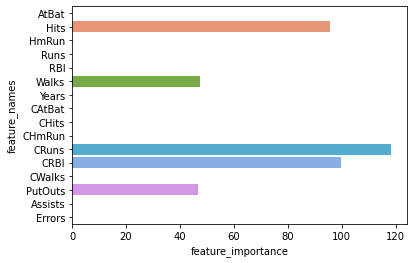

In [85]:
import seaborn as sns

sns.barplot(x='feature_importance', y='feature_names', data=df_coef);

## Feature selection

### Filter method 

In this example, we use feature importance as a filter to select our features. In particular, we want to select the two features which are the most important according to the coefficients. The function `SelectFromModel` is meant just for that. `SelectFromModel` accepts a threshold parameter and will select the features whose importance (defined by the coefficients) are above this threshold.

In our case, we want to select only 2 features. Hence, we will set the threshold slightly above the coefficient of the third most important feature. We also record the time the algorithm takes to obtain the results.

In [86]:
from sklearn.feature_selection import SelectFromModel
import numpy as np
from time import time

# set threshold
threshold = np.sort(df_coef.feature_importance)[-3] + 1
feature_names =  np.array(df_coef.feature_names)

# obtain time
tic = time()

# fit model
sfm = SelectFromModel(reg, threshold=threshold).fit(X_train, y_train)

# obtain time
toc = time()

# print results
print(f"Features selected by SelectFromModel: {feature_names[sfm.get_support()]}")
print(f"Done in {toc - tic:.3f}s")

Features selected by SelectFromModel: ['CRuns' 'CRBI']
Done in 0.110s


### Wrapper method 

Another way of selecting features is to use a (greedy) wrapper method with scikit learn's `SequentialFeatureSelector` (SFS). SFS is a greedy procedure where, at each iteration, we choose the best new feature to add to our selected features based a cross-validation score: 

- `Forward-Selection`: That is, we start with 0 features and choose the best single feature with the highest score. The procedure is repeated until we reach the desired number of selected features.

- `Backward selection`: We can also go in the reverse direction (backward SFS), i.e. start with all the features and greedily choose features to remove one by one. We illustrate both approaches here.

#### Forward selection

In [87]:
from sklearn.feature_selection import SequentialFeatureSelector

tic_fwd = time()

sfs_forward = SequentialFeatureSelector(
    reg, n_features_to_select=2, 
    direction="forward").fit(X_train, y_train)

toc_fwd = time()

In [72]:
print(
    "Features selected by forward sequential selection: "
    f"{feature_names[sfs_forward.get_support()]}"
)
print(f"Done in {toc_fwd - tic_fwd:.3f}s")

Features selected by forward sequential selection: ['Hits' 'CRBI']
Done in 5.069s


#### Backward selection

In [89]:
tic_bwd = time()

sfs_backward = SequentialFeatureSelector(
    reg, n_features_to_select=2, 
    direction="backward").fit(X_train, y_train)

toc_bwd = time()

In [90]:
print(
    "Features selected by backward sequential selection: "
    f"{feature_names[sfs_backward.get_support()]}"
)
print(f"Done in {toc_bwd - tic_bwd:.3f}s")

Features selected by backward sequential selection: ['Hits' 'CRBI']
Done in 34.424s


## Discussion

To finish with, we should note that 

- `SelectFromModel` is significantly faster than SFS since `SelectFromModel` only needs to fit a model once, while SFS needs to cross-validate many different models for each of the iterations.

- SFS however works with any model, while `SelectFromModel` requires the underlying estimator to expose a `coef_` attribute or a `feature_importances_` attribute. 

- Forward selection is much faster than backward selection because it only needs to perform `n_features_to_select = 2` iterations, while the backward selection needs to perform `n_features` - `n_features_to_select`.